In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
import rigidbody.transformations as trans
# import rigidbody.plotter as plotter
# plotter.set_context("paper")

In [3]:
R = trans.rotation_matrix_x(np.pi/3)

In [4]:
R

array([[ 1.       ,  0.       ,  0.       ],
       [ 0.       ,  0.5      , -0.8660254],
       [ 0.       ,  0.8660254,  0.5      ]])

In [5]:
k, theta = trans.axis_angle_from_rot_matrix(R)

In [6]:
k

array([1., 0., 0.])

In [7]:
R = trans.rotation_matrix_z(np.pi/6)@trans.rotation_matrix_y(np.pi/3)@trans.rotation_matrix_z(np.pi/6)

In [8]:
trans.euler_angles_from_rot_matrix(R)*180/np.pi

array([30., 60., 30.])

In [9]:
R = trans.rotation_matrix_z(np.pi/2)@trans.rotation_matrix_y(np.pi/6)@trans.rotation_matrix_x(np.pi/3)

In [10]:
trans.roll_pitch_yaw_angles_from_rot_matrix(R)*180/np.pi

array([90., 30., 60.])

In [11]:
R_10 = trans.rotation_matrix_x(np.pi/2)@trans.rotation_matrix_z(np.pi/2)

In [12]:
R_21 = trans.rotation_matrix_z(np.pi/2)@trans.rotation_matrix_y(np.pi/2)

In [13]:
R_20 = R_10@R_21

In [14]:
R_20

array([[-6.1232340e-17, -1.2246468e-16, -1.0000000e+00],
       [ 1.0000000e+00, -6.1232340e-17, -6.1232340e-17],
       [-6.1232340e-17, -1.0000000e+00,  1.2246468e-16]])

In [15]:
R_10

array([[ 6.12323400e-17, -1.00000000e+00,  0.00000000e+00],
       [ 6.12323400e-17,  3.74939946e-33, -1.00000000e+00],
       [ 1.00000000e+00,  6.12323400e-17,  6.12323400e-17]])

## Homogeneous Transformation

`trans_x` is not commutative with `rot_z`.

In [16]:
trans_x = trans.trans_x(2)
trans_x_inv =  trans.trans_x(-2)
trans_y = trans.trans_y(2)
trans_y_inv = trans.trans_y(-2)
rot_z = trans.rot_z(np.pi/6)



In [17]:
trans_x@rot_z - rot_z@trans_x

array([[ 0.        ,  0.        ,  0.        ,  0.26794919],
       [ 0.        ,  0.        ,  0.        , -1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [18]:
trans_x@trans_y-trans_y@trans_x

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [88]:
def plot_patch(poly, Po_i, ax, index, colors=['red','green','blue','magenta','black','yelllow']): # max 6):
    ax.add_patch(poly)
    middle = np.mean(poly.xy[:3,:],axis=0)

    # ax.text(middle[0],middle[1],r'$P^{}$'.format(tag))
    ax.scatter(middle[0],middle[1],color=colors[index])
    ax.text(middle[0]-0.15,middle[1]-0.15,r'$o_{}$'.format(index))

    plt.arrow(Po_i[0,0],Po_i[0,1],Po_i[1,0]-Po_i[0,0],Po_i[1,1]-Po_i[0,1],color='black',head_width=0.05, head_length=0.1)
    plt.arrow(Po_i[2,0],Po_i[2,1],Po_i[3,0]-Po_i[2,0],Po_i[3,1]-Po_i[2,1],color='black',head_width=0.05, head_length=0.1)
    ax.text(Po_i[1,0],Po_i[1,1],r'$x_{}$'.format(index))
    ax.text(Po_i[3,0],Po_i[3,1],r'$y_{}$'.format(index))

# we will draw everything according to the o0 frame
# o0 frame is the frame of the body at the beginning.
# now the points coordinate at any time with respects to the body frame will always be equal to their
# coordinate values on o0 frame. see p18/39
def draw_triangles(operations:list,
                   file_name=None,
                   limits=np.array([[-5,5],[-5,5]]),
                   ax=None):
    
    # these points are given in frame o0 before movement.
    # after movements, they are the same according to the body frame, but have different values in the o0 frame.
    points = np.array([[-1.,-2,0],
    [1,-2,0],
    [0,3,0]])
    
    middle = np.mean(points,axis=0)
    points[:,0] -= middle[0]
    points[:,1] -= middle[1]
    
    # frames
    o0 = np.array([[0,0,0.],
                [0.5,0,0.],
                [0,0,0.],
                [0,1,0.]]) # a unit vector at the direction of x0
    frames = []
    frames.append(o0)

    # operations must be reversed! [A,B,C] P -> A(B(C(P)))
    # the result should be [P, C(P), B(C(P)), A(B(C(P)))]
    # or [A(B(C(P))), B(C(P)), C(P), P]
    operations.reverse() # because otherwise A will be applied first to which is wrong.!
    
    Ps = []
    Ps_ = trans.homogeneous_representation(points) #this will be the value according to the last frame.
    Ps.append(Ps_)
    for oper in operations:
        Ps_T = oper@(Ps_.T) #this is not given in the o0 frame, but in some other frame!
        Ps_ = Ps_T.T
        Ps.append(Ps_)
    

    Po = []
    Po_ = trans.homogeneous_representation(o0)
    Po.append(Po_)
    for oper in operations:
        Po_T = oper@(Po_.T)
        Po_ = Po_T.T
        Po.append(Po_)

    
    

    polys=[]
    
    colors=['red','green','blue','magenta','black','yelllow'] # max 6
    for i,Ps_ in enumerate(Ps):
        tag = i
        polys.append(Polygon(Ps_[:,:2],fill=False,edgecolor=colors[tag])) 

    new_plot = False
    if ax is None:
        new_plot = True
        fig, ax = plt.subplots(1,1,dpi=300)
    
    if new_plot:
        plot_patch(polys[0], Po[0], ax, 0)
    
    # plot the last
    index = len(polys)-1
    plot_patch(polys[index], Po[index], ax, index)

    # for i,poly in enumerate(polys):
        # if i == 0 or i == len(polys)-1:
            # ax.add_patch(poly)
            # middle = np.mean(poly.xy[:3,:],axis=0)

            # tag = i
            # # ax.text(middle[0],middle[1],r'$P^{}$'.format(tag))
            # ax.scatter(middle[0],middle[1],color=colors[tag])
            # ax.text(middle[0]-0.15,middle[1]-0.15,r'$o_{}$'.format(tag))

            # # draw frame
            # Po_i = Po[i]
            # plt.arrow(Po_i[0,0],Po_i[0,1],Po_i[1,0]-Po_i[0,0],Po_i[1,1]-Po_i[0,1],color='black',head_width=0.05, head_length=0.1)
            # plt.arrow(Po_i[2,0],Po_i[2,1],Po_i[3,0]-Po_i[2,0],Po_i[3,1]-Po_i[2,1],color='black',head_width=0.05, head_length=0.1)
            # ax.text(Po_i[1,0],Po_i[1,1],r'$x_{}$'.format(tag))
            # ax.text(Po_i[3,0],Po_i[3,1],r'$y_{}$'.format(tag))
        

    plt.ylim(*limits[0])
    plt.xlim(*limits[1])
    ax.set_aspect('equal')
    plt.tight_layout()
    # plt.grid(which='both',linewidth=0.5)
    if not file_name:
        plt.savefig('{}.svg'.format(file_name))
    return Ps, Po, ax

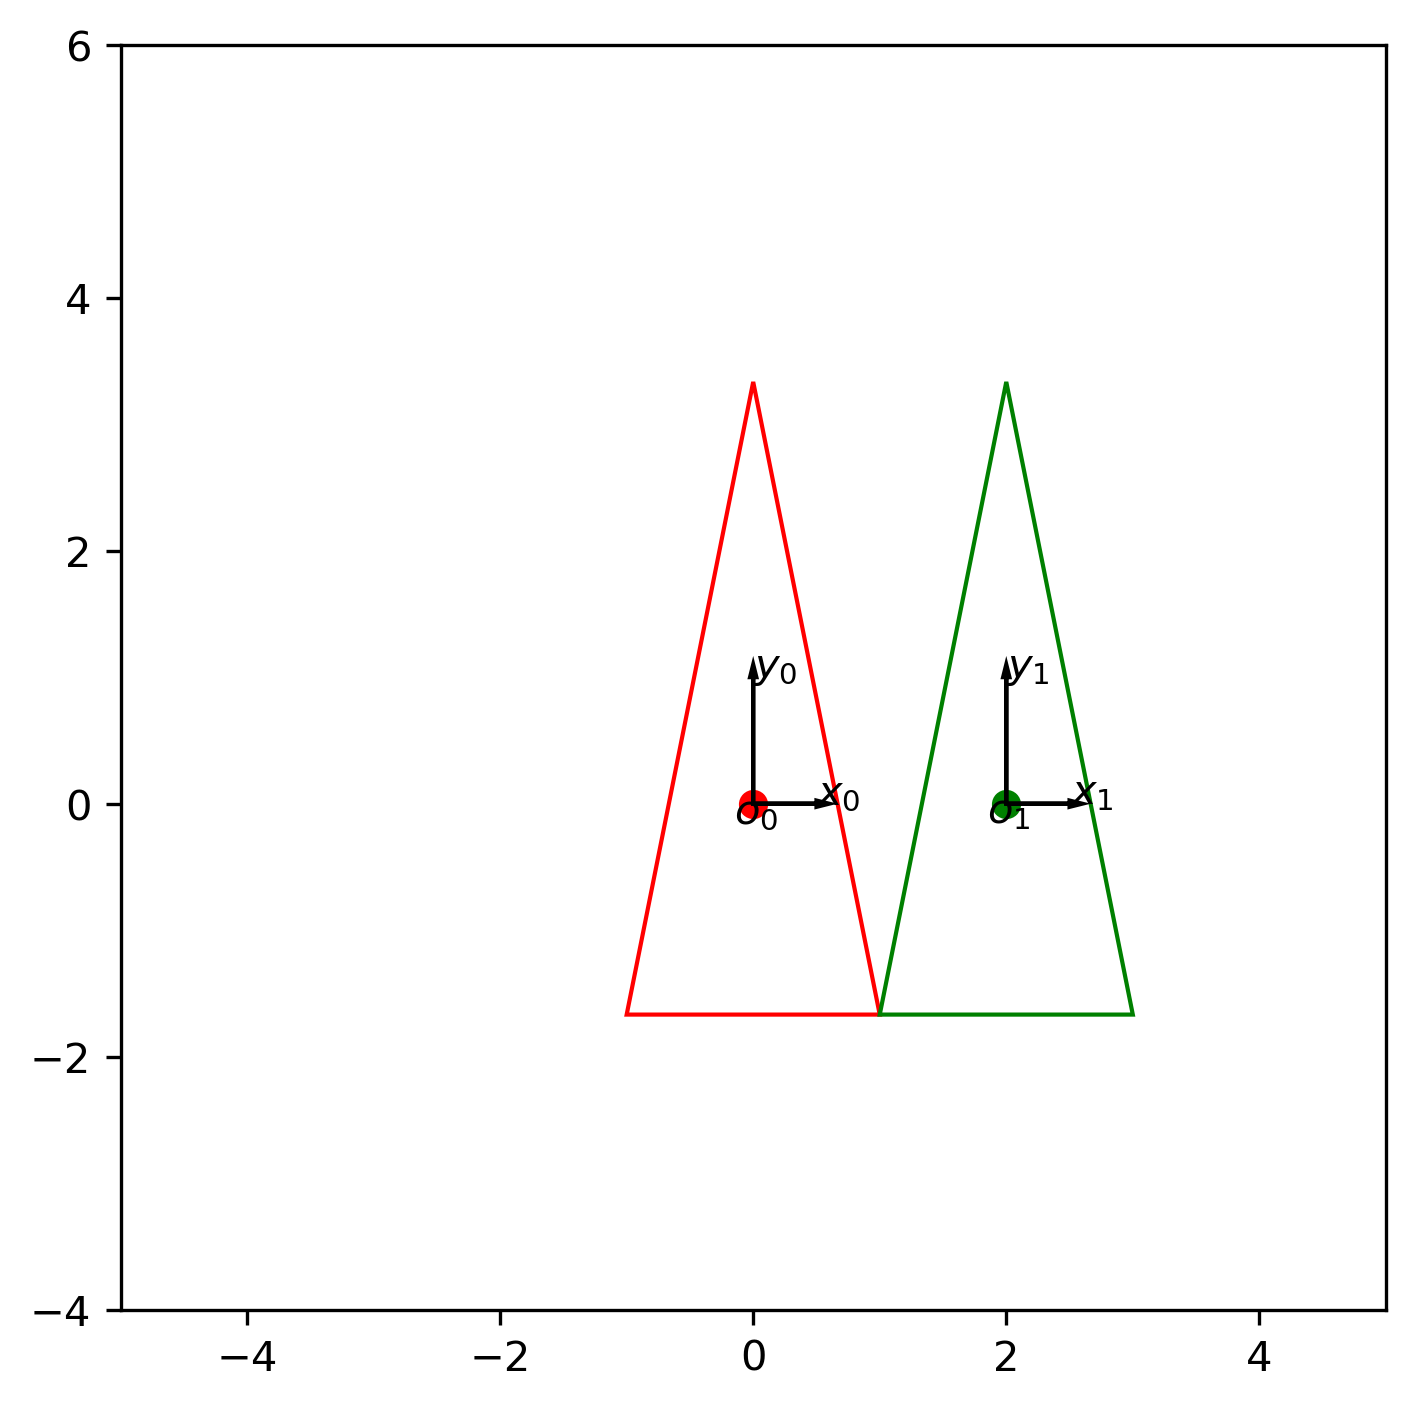

In [89]:
# NEW VERSION
Ps, Po, _ = draw_triangles([trans_x], 'trans_x',limits=np.array([[-4,6],[-5,5]]))

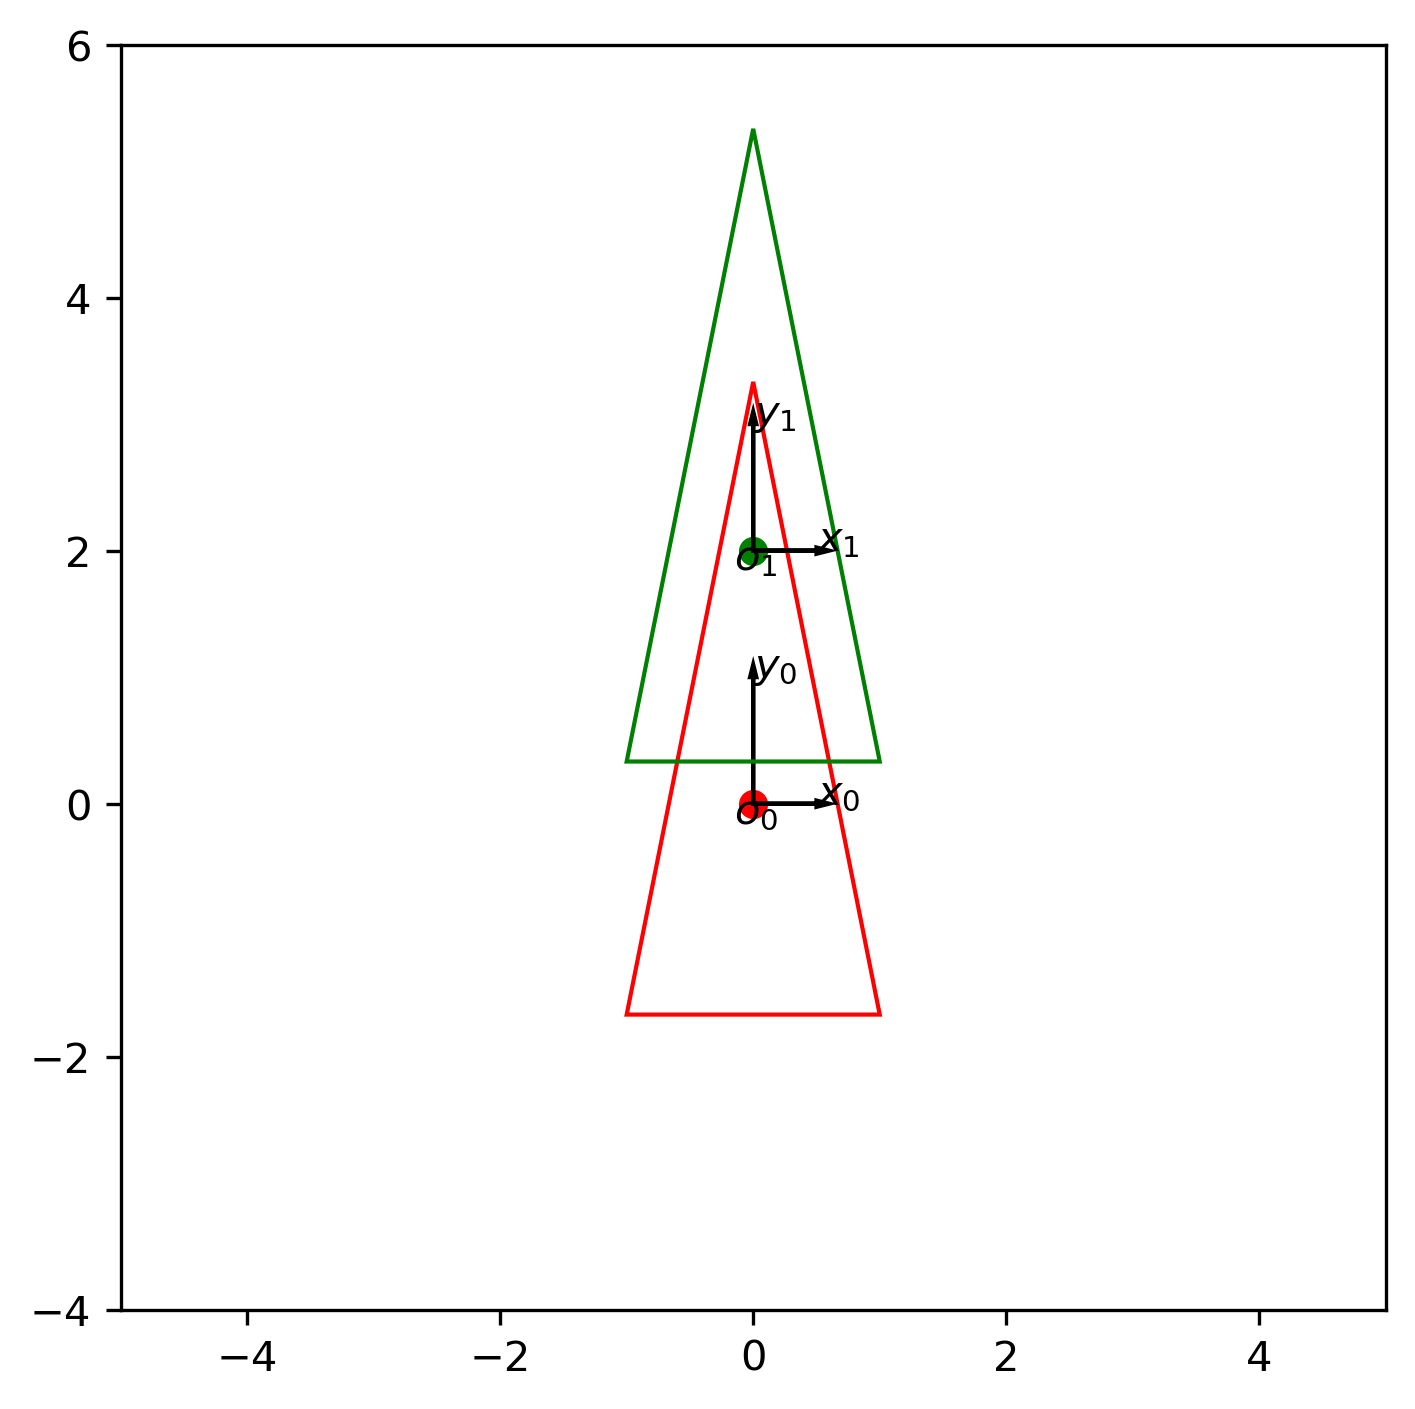

In [90]:
Ps, Po, _ = draw_triangles([trans_y], 'trans_y',limits=np.array([[-4,6],[-5,5]]))

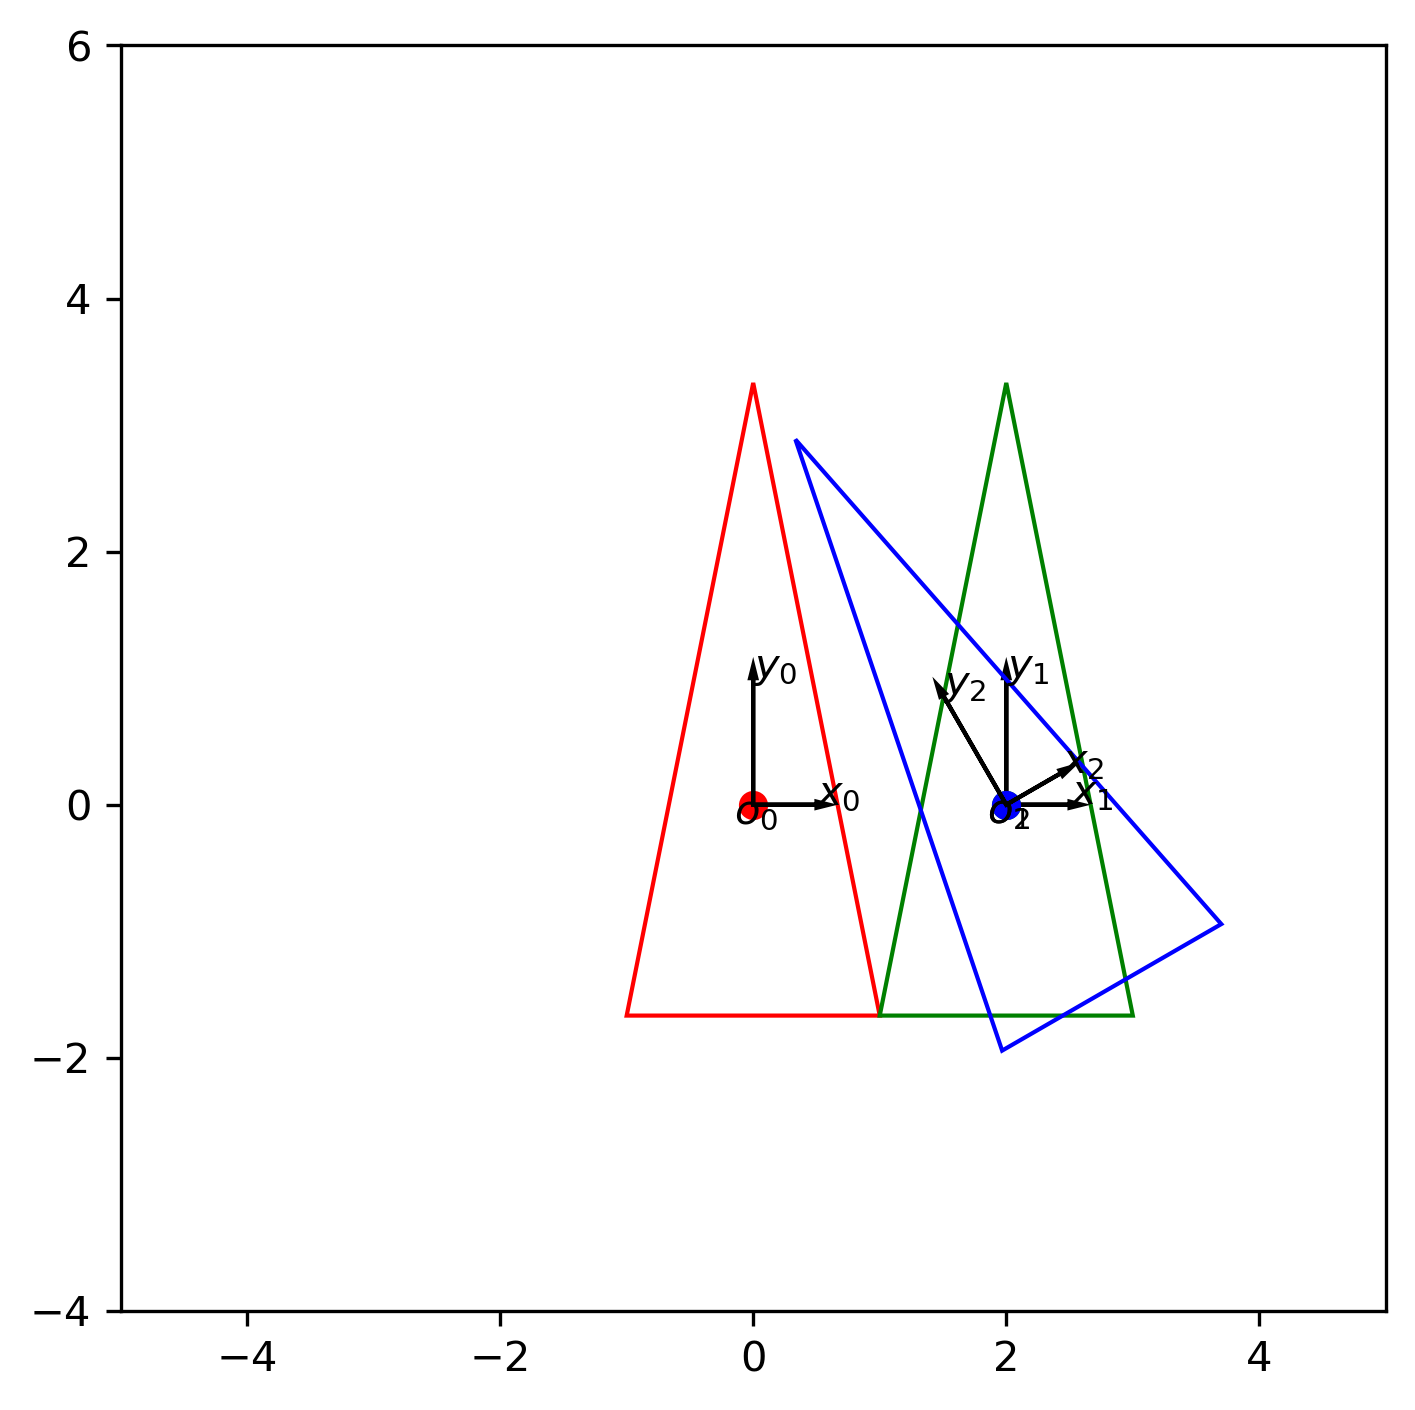

In [91]:
_,_,ax = draw_triangles([trans_x], file_name=None,limits=np.array([[-4,6],[-5,5]]))
_,_,ax = draw_triangles([trans_x,rot_z], 'trans_x_rot_z',limits=np.array([[-4,6],[-5,5]]),ax=ax)
# kalau current frame liatnya dari belakang

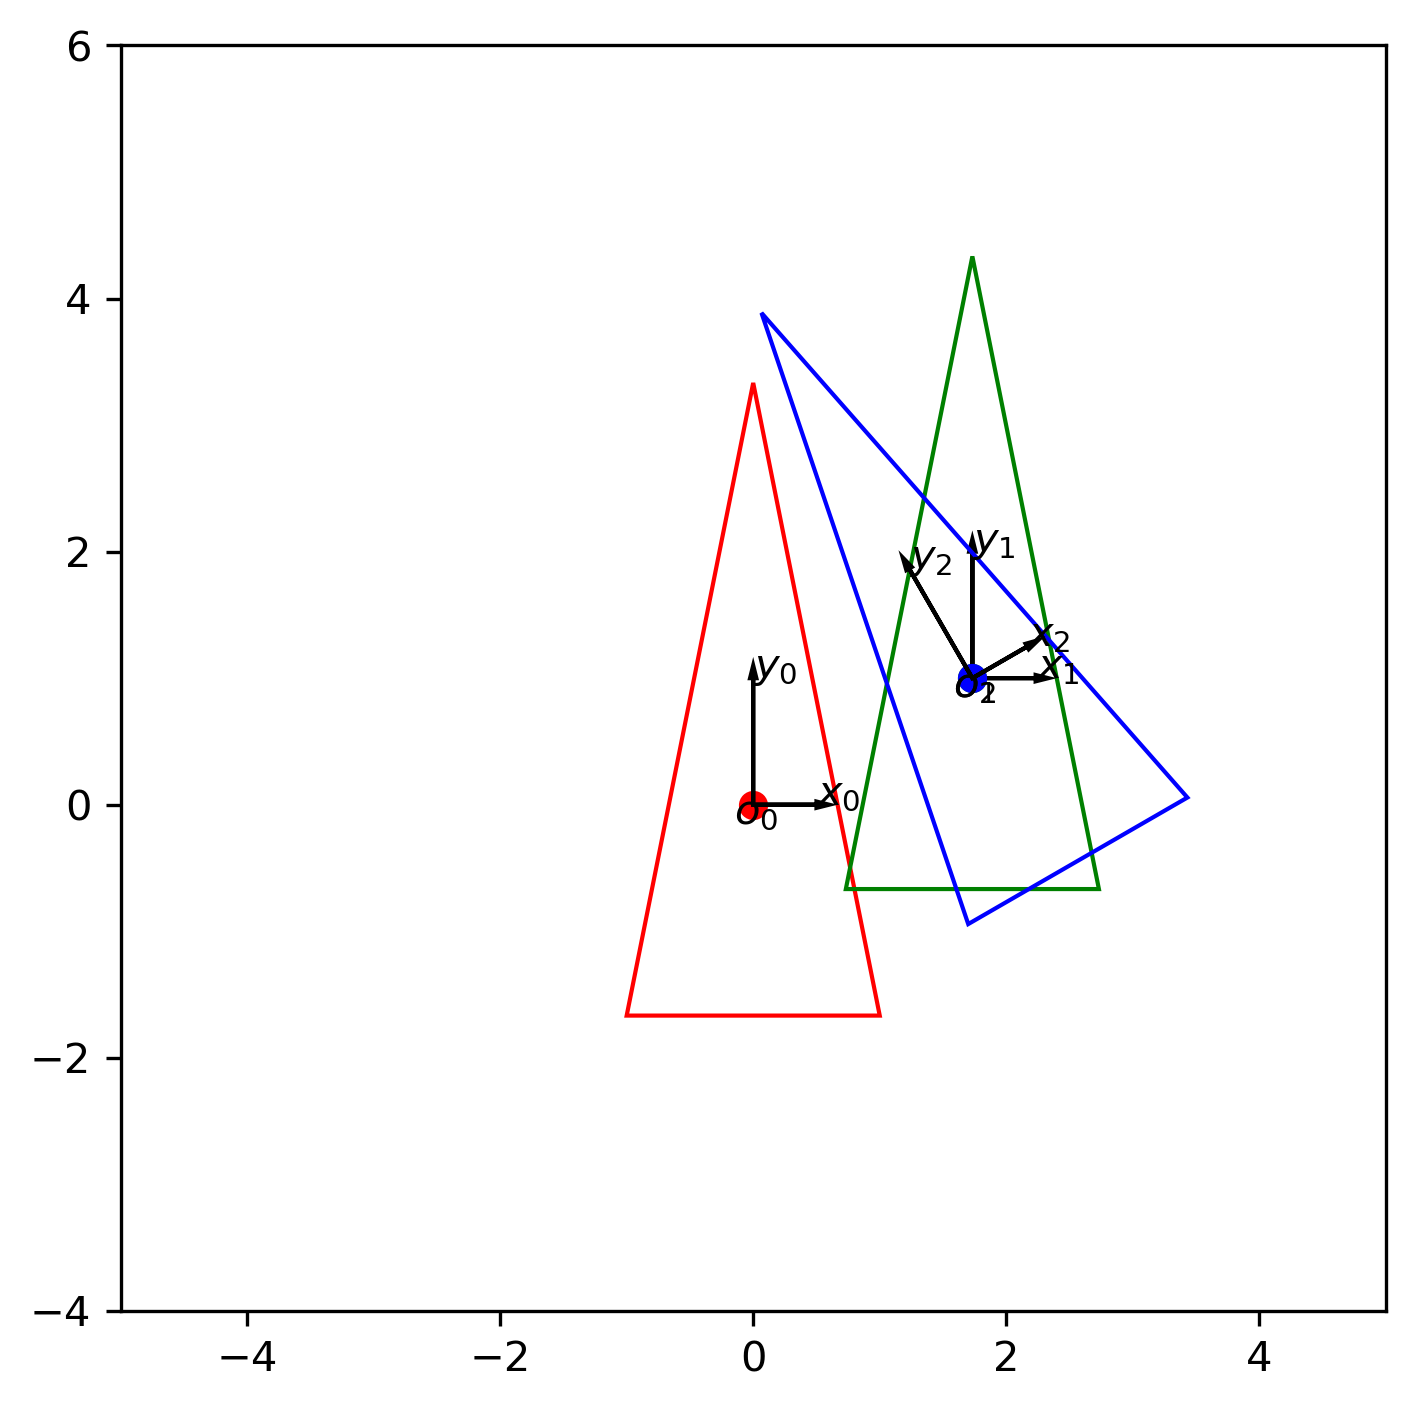

In [92]:
# since trans_x is still described in frame
H_1_2 = rot_z
H_0_1 = H_1_2@trans_x@np.linalg.inv(H_1_2)
_,_,ax = draw_triangles([H_0_1], file_name=None,limits=np.array([[-4,6],[-5,5]]))
_,_,ax = draw_triangles([H_0_1,H_1_2], 'trans_x_11_rot_z',limits=np.array([[-4,6],[-5,5]]),ax=ax)
# question: why the rotation seems not correct? Because the origin is still prescribed at the old frame (o0). To get this correct,
# we need to transform rot_z to frame o1

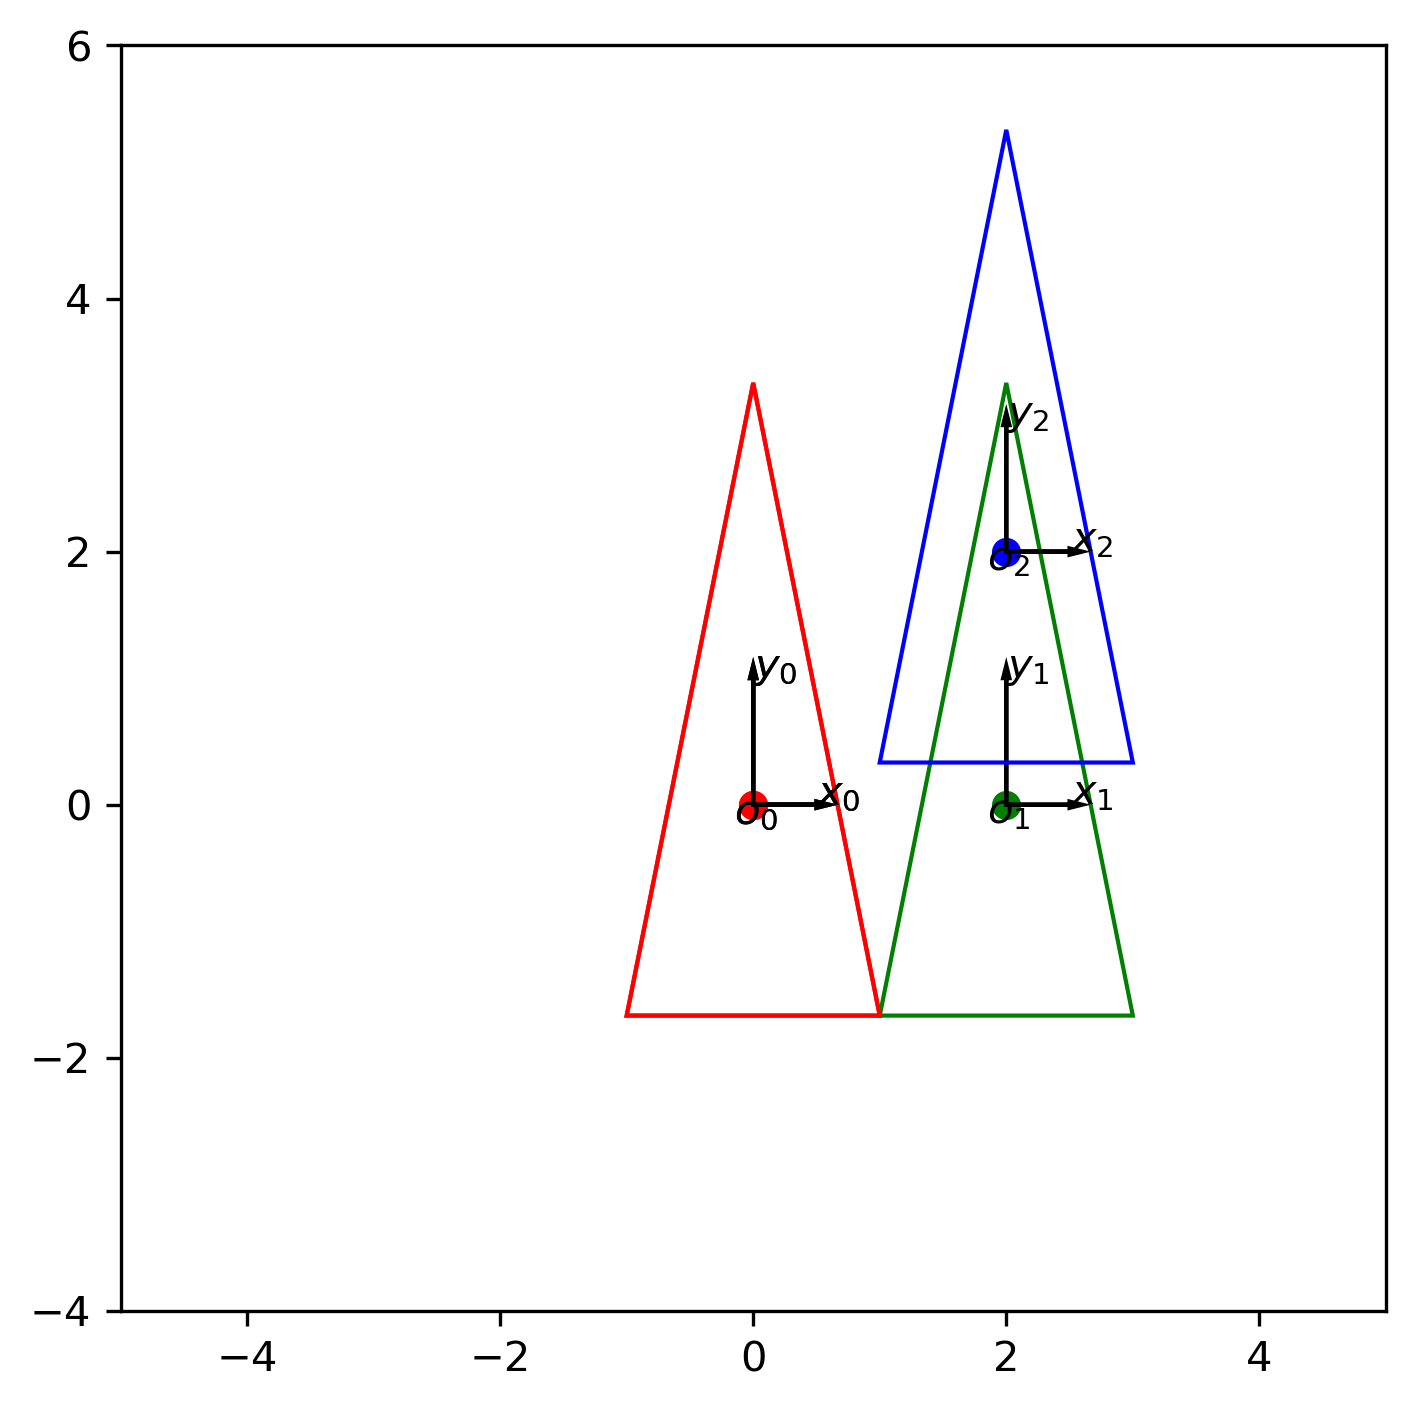

In [79]:
# some more
_, _, ax = draw_triangles([trans_x], file_name=None,limits=np.array([[-4,6],[-5,5]]))
_, _, _ = draw_triangles([trans_x,trans_y], 'trans_x_trans_y',limits=np.array([[-4,6],[-5,5]]),ax=ax)

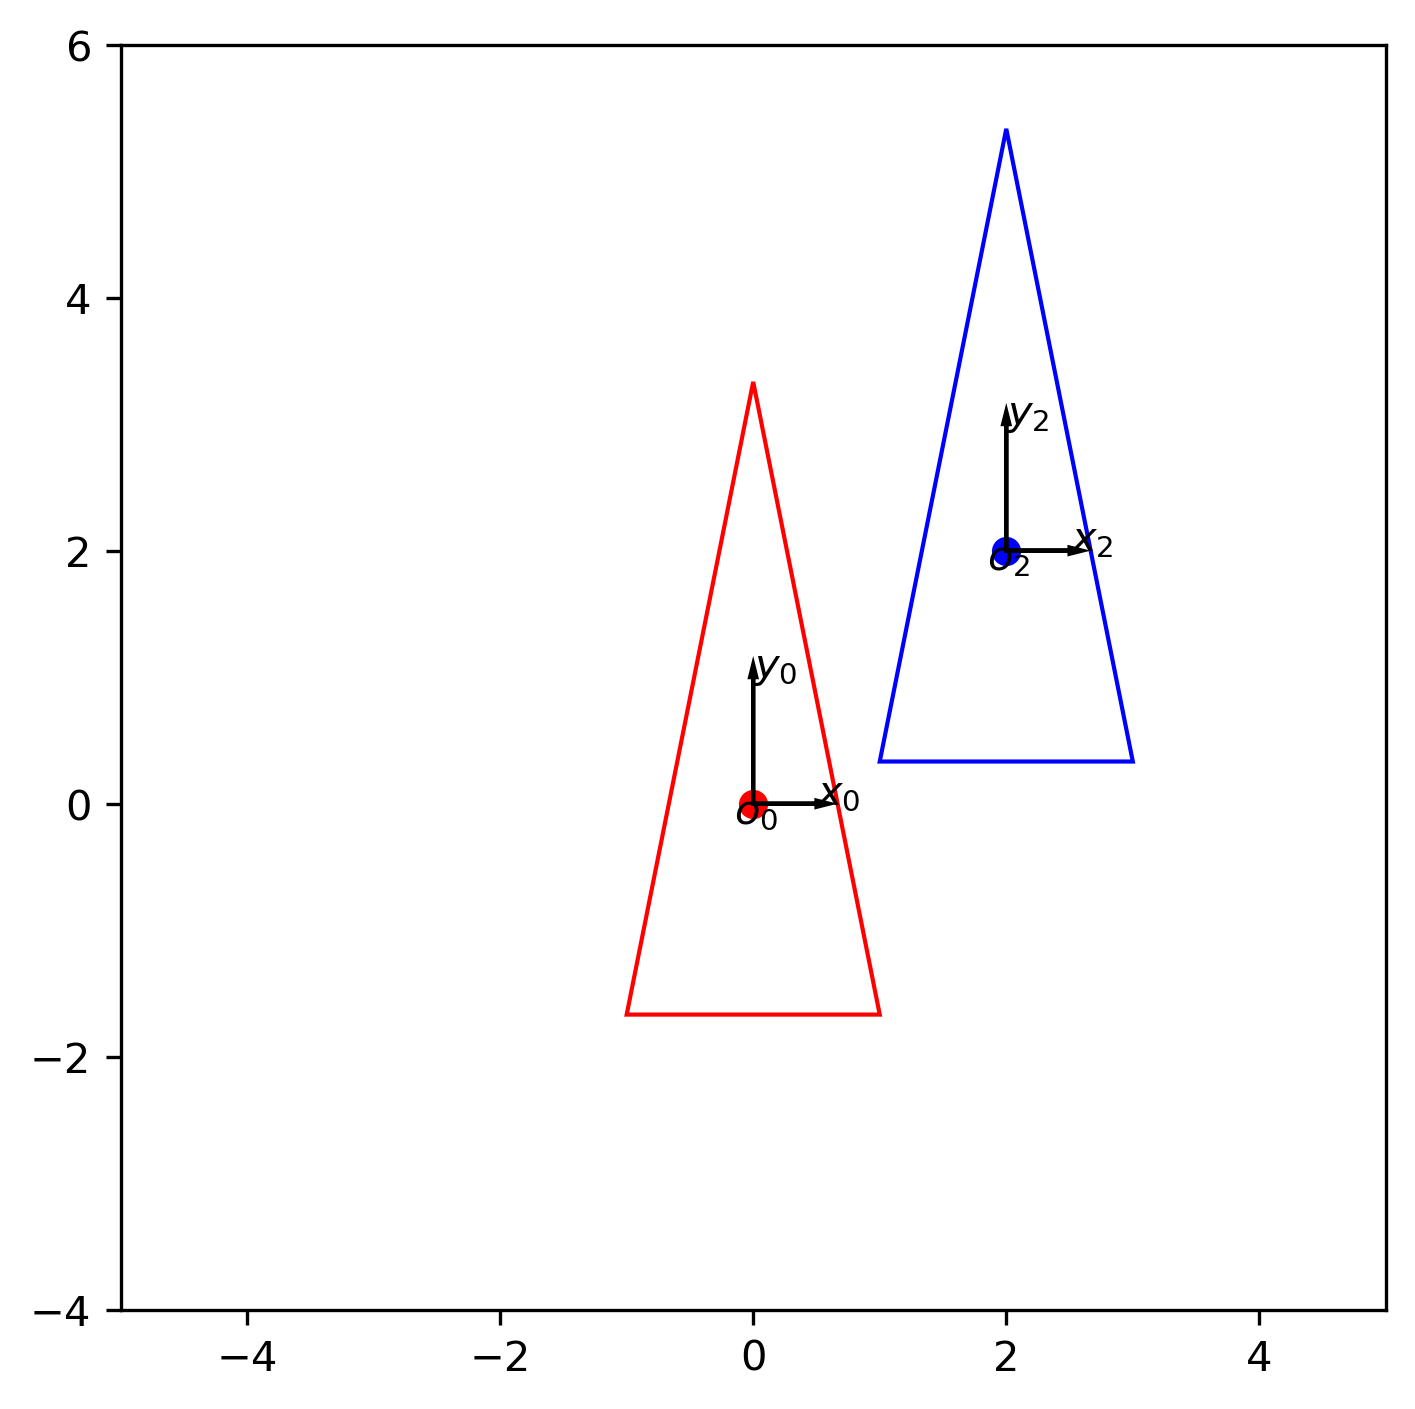

In [98]:
Ps, Po, _ = draw_triangles([trans_y,trans_x],'trans_y_trans_x',limits=np.array([[-4,6],[-5,5]]))


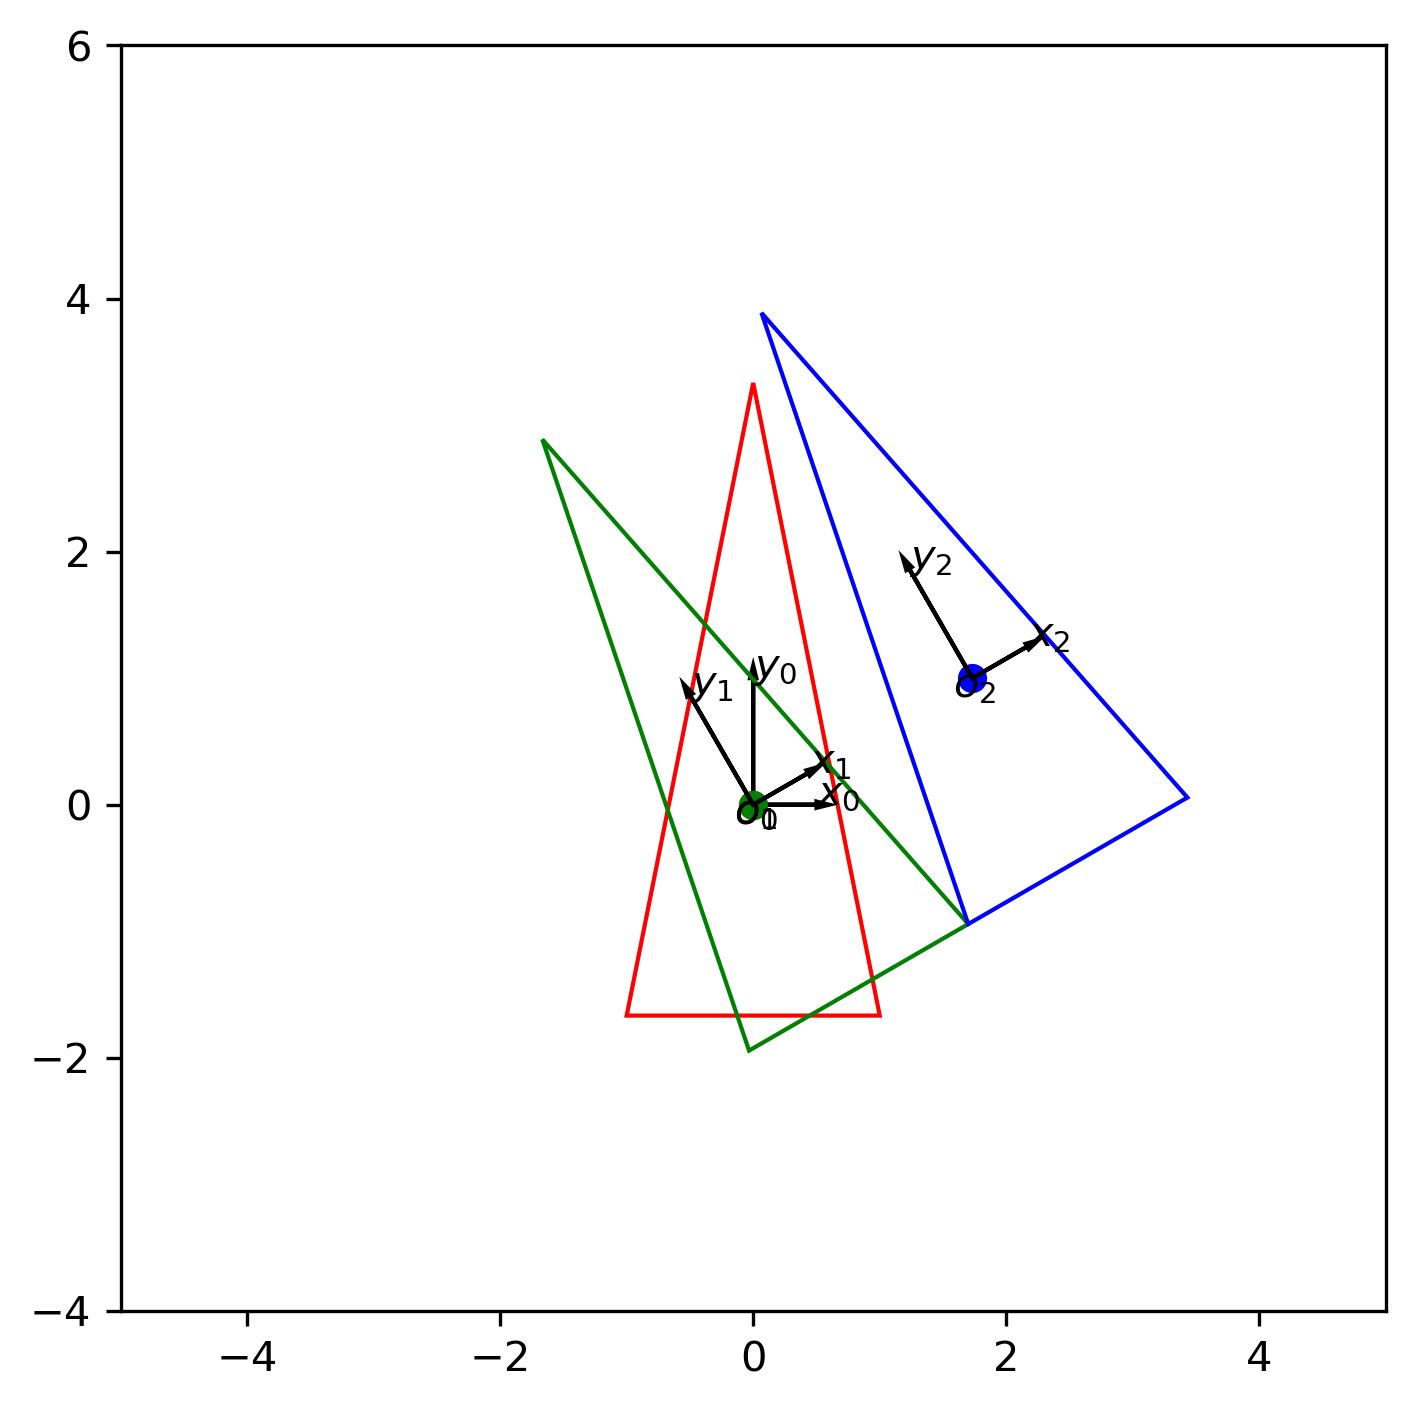

In [101]:
H_0_1 = rot_z
H_1_2 = trans_x # the translation is prescribed still in frame 0
Ps, Po, ax = draw_triangles([H_0_1],limits=np.array([[-4,6],[-5,5]]))
Ps, Po, _ = draw_triangles([H_0_1,H_1_2],'rot_z_trans_x',limits=np.array([[-4,6],[-5,5]]), ax=ax)

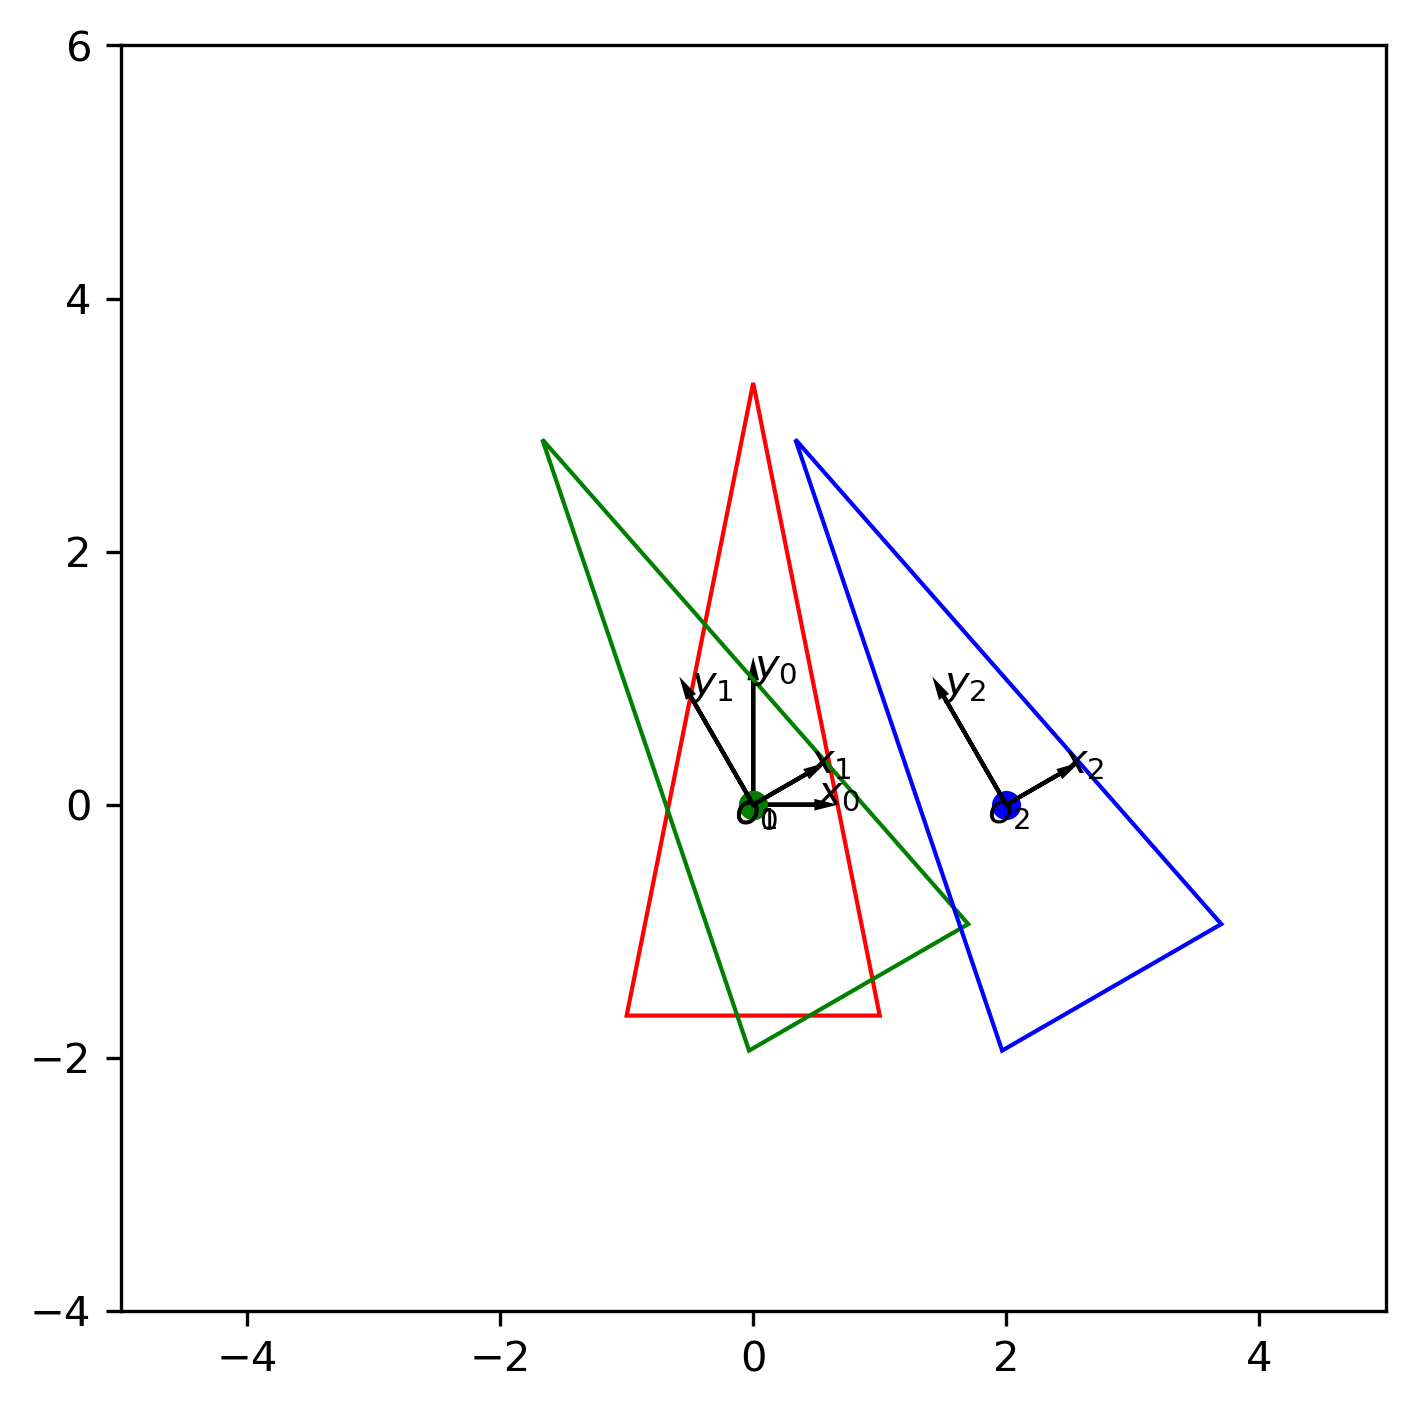

In [104]:
H_0_1 = rot_z
H_1_2 = np.linalg.inv(H_0_1)@trans_x@H_0_1 # the translation is prescribed in frame 1
Ps, Po, ax = draw_triangles([H_0_1],limits=np.array([[-4,6],[-5,5]]))
Ps, Po, _ = draw_triangles([H_0_1,H_1_2],'rot_z_trans_x_11',limits=np.array([[-4,6],[-5,5]]), ax=ax)

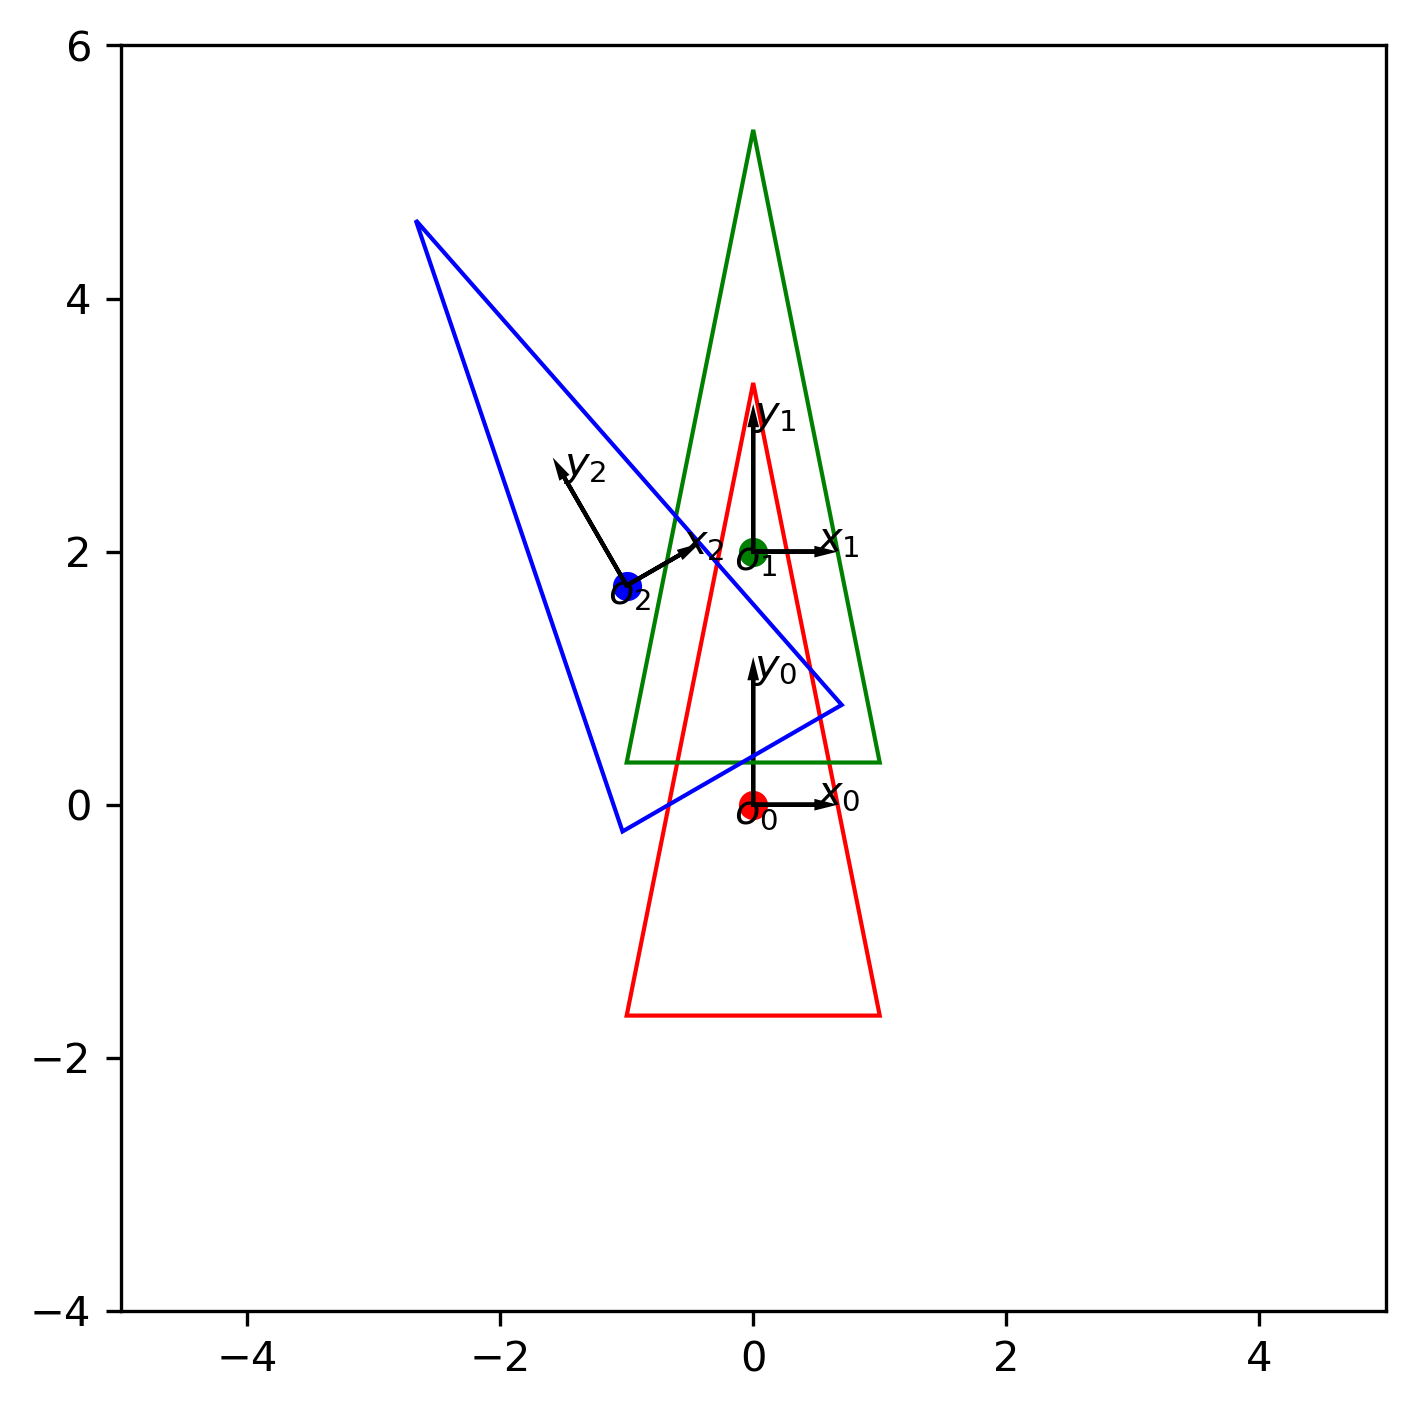

In [106]:
# Now if we need to express rotation about z in with the shifted center, then A^1_1 = R_z,theta. In frame 0, we should use A^0_0, which is given by (H^1_0)^{-1}A^0_0 H^1_0.
# H^1_0 is frame o0 with respect to o1(after shifting)

# since  rot_z is described in frame o0; i.e, it is rot_z_0_0, we need to get it as rot_z_1_1
H_0_1 = trans_y
rot_z_11 = np.linalg.inv(H_0_1)@rot_z@H_0_1
Ps, Po, ax = draw_triangles([H_0_1],limits=np.array([[-4,6],[-5,5]]))
Ps, Po, _ = draw_triangles([H_0_1,rot_z_11],'trans_y_rot_z_11',limits=np.array([[-4,6],[-5,5]]),ax=ax)



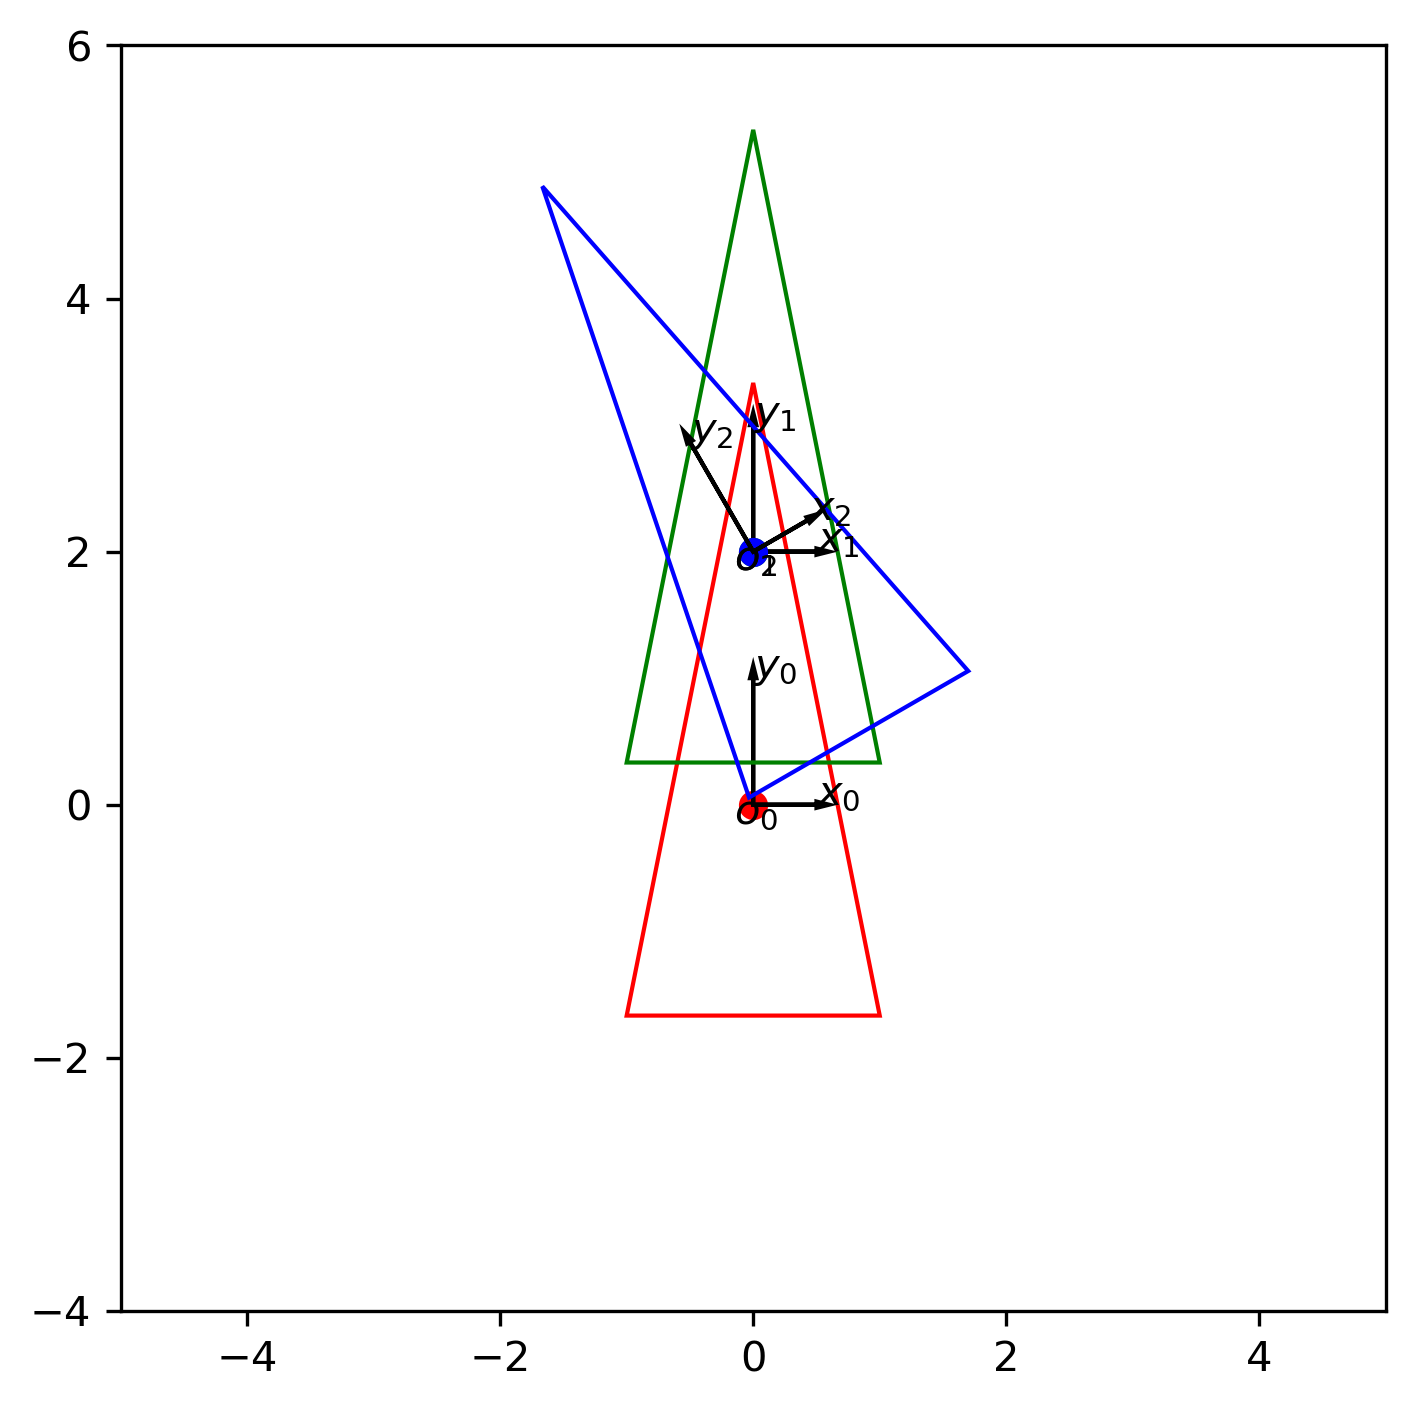

In [107]:
# This is what happened if you did not prescribe it on the correct frame

# since  rot_z is described in frame o0; i.e, it is rot_z_0_0, we need to get it as rot_z_1_1
H_0_1 = trans_y
H_0_2 = rot_z
Ps, Po, ax = draw_triangles([H_0_1],limits=np.array([[-4,6],[-5,5]]))
Ps, Po, _ = draw_triangles([H_0_1,H_0_2],'trans_y_rot_z_00',limits=np.array([[-4,6],[-5,5]]), ax=ax)